In [1]:
pip install mealpy==2.5.4

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.0/92.0 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 378.0/378.0 kB 17.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 88.5 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install mafese==0.1.9

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 20.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.6/52.6 kB 3.5 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [3]:
# imports

import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import mafese as mfse

2024-04-29 14:36:53.988272: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-29 14:36:53.988365: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-29 14:36:54.117188: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
# loading the images
train_dir = "/kaggle/input/cifake-real-and-ai-generated-synthetic-images/train"
test_dir = "/kaggle/input/cifake-real-and-ai-generated-synthetic-images/test"

# generator
def datagen(func):
  train_gen = tf.keras.preprocessing.image.ImageDataGenerator(
              preprocessing_function=func,
              horizontal_flip = True,
              vertical_flip = True,
              rotation_range = 0.5,
              width_shift_range = 0.25,
              height_shift_range = 0.25,
              shear_range = 0.2,
              zoom_range = 0.4,
              validation_split = 0.92)

  test_gen = tf.keras.preprocessing.image.ImageDataGenerator(
              preprocessing_function=func,
              validation_split = 0.8)

  test_gen_2 = tf.keras.preprocessing.image.ImageDataGenerator(
              preprocessing_function=func,
              validation_split = 0.2)

  pred_gen = tf.keras.preprocessing.image.ImageDataGenerator(
              preprocessing_function=func,
              validation_split = 0.92)

  train_set = train_gen.flow_from_directory(train_dir, class_mode = "binary", batch_size = 128, target_size = (224,224), shuffle = True, subset = 'training')
  test_set = test_gen.flow_from_directory(test_dir, class_mode = "binary", batch_size = 128, target_size = (224,224), shuffle = False, subset='training')
  val_set = test_gen_2.flow_from_directory(test_dir, class_mode = "binary", batch_size = 128, target_size = (224,224), shuffle = False, subset='validation')
  pred_tr_set = pred_gen.flow_from_directory(train_dir, class_mode = "binary", batch_size = 128, target_size = (224,224), shuffle = False, subset = 'training')
  return train_set, test_set, val_set, pred_tr_set

In [5]:
# model
base_model = tf.keras.applications.NASNetLarge(include_top=False, weights='imagenet', input_shape=(224,224,3))
base_model.trainable = False
inputs = tf.keras.Input(shape=(224,224,3))
x = base_model(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
outputs = tf.keras.layers.Dense(2, activation="softmax")(x)
model = tf.keras.Model(inputs, outputs)
model.summary()
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics
              =["accuracy"])

343610240/343610240 ━━━━━━━━━━━━━━━━━━━━ 9s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ NASNet (Functional)             │ (None, 7, 7, 4032)     │    84,916,818 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 4032)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2)              │         8,066 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 84,924,884 (323.96 MB)

 Trainable params: 8,066 (31.51 KB)

 Non-trainable params: 84,916,818 (323.93 MB)

In [6]:
len(model.layers[1].layers)

1039

In [7]:
tr_set, te_set, v_set, pr_set = datagen(tf.keras.applications.nasnet.preprocess_input)

Found 8000 images belonging to 2 classes.
Found 4000 images belonging to 2 classes.
Found 4000 images belonging to 2 classes.
Found 8000 images belonging to 2 classes.


In [8]:
# callback and fit
early_stopping_callbacks = [tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 10, restore_best_weights = True, verbose = 1),
                            tf.keras.callbacks.ReduceLROnPlateau(paitence = 10, monitor = 'val_loss', min_lr = 0.00001)]

history = model.fit(tr_set, epochs = 100, validation_data = v_set, callbacks = early_stopping_callbacks)

Epoch 1/100


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.

I0000 00:00:1714401647.385496      84 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1714401647.681841      84 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5554 - loss: 0.7123

W0000 00:00:1714401809.531224      85 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


63/63 ━━━━━━━━━━━━━━━━━━━━ 288s 3s/step - accuracy: 0.5561 - loss: 0.7117 - val_accuracy: 0.6693 - val_loss: 0.6020 - learning_rate: 1.0000e-04
Epoch 2/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 118s 2s/step - accuracy: 0.6742 - loss: 0.6043 - val_accuracy: 0.7210 - val_loss: 0.5539 - learning_rate: 1.0000e-04
Epoch 3/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 116s 2s/step - accuracy: 0.7141 - loss: 0.5595 - val_accuracy: 0.7460 - val_loss: 0.5243 - learning_rate: 1.0000e-04
Epoch 4/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 117s 2s/step - accuracy: 0.7435 - loss: 0.5205 - val_accuracy: 0.7570 - val_loss: 0.5094 - learning_rate: 1.0000e-04
Epoch 5/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 116s 2s/step - accuracy: 0.7581 - loss: 0.5080 - val_accuracy: 0.7660 - val_loss: 0.5001 - learning_rate: 1.0000e-04
Epoch 6/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 117s 2s/step - accuracy: 0.7662 - loss: 0.4993 - val_accuracy: 0.7750 - val_loss: 0.4801 - learning_rate: 1.0000e-04
Epoch 7/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 116s 2s/step - accuracy: 0.7712 - los

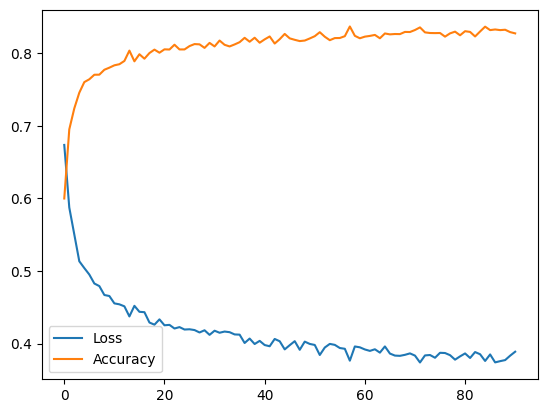

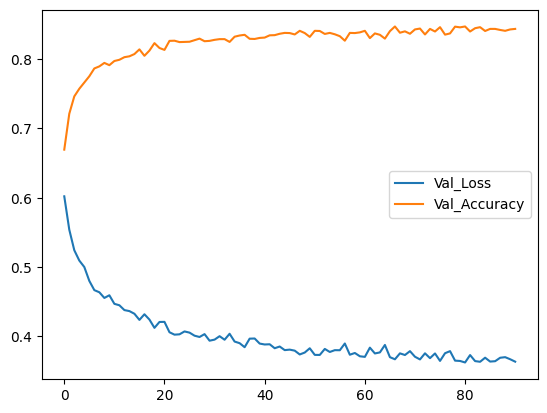

In [9]:
# loss curve

l = np.concatenate([history.history['loss']])
acc = np.concatenate([history.history['accuracy']])
lv = np.concatenate([history.history['val_loss']])
accv = np.concatenate([history.history['val_accuracy']])

plt.plot(l, label="Loss")
plt.plot(acc, label="Accuracy")
plt.legend()
plt.show()
plt.plot(lv, label="Val_Loss")
plt.plot(accv, label="Val_Accuracy")
plt.legend()
plt.show()

In [10]:
model.save("nasnetlarge_pretrain_2.keras")

In [11]:
# fine tune

base_model = model.layers[1]
base_model.trainable = True

fine_tune_at = 970

for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

early_stopping_callbacks = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 10,restore_best_weights = True, verbose = 1)


model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001), metrics
              =["accuracy"])

history_ft = model.fit(tr_set, epochs = 50, validation_data = te_set, callbacks = [early_stopping_callbacks])

Epoch 1/50
 1/63 ━━━━━━━━━━━━━━━━━━━━ 1:11:44 69s/step - accuracy: 0.7812 - loss: 0.4196

W0000 00:00:1714412594.391432      83 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8253 - loss: 0.4004

W0000 00:00:1714412695.518949      84 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


63/63 ━━━━━━━━━━━━━━━━━━━━ 238s 3s/step - accuracy: 0.8252 - loss: 0.4004 - val_accuracy: 0.8250 - val_loss: 0.3921
Epoch 2/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 117s 2s/step - accuracy: 0.8210 - loss: 0.4018 - val_accuracy: 0.8255 - val_loss: 0.3909
Epoch 3/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 118s 2s/step - accuracy: 0.8419 - loss: 0.3693 - val_accuracy: 0.8340 - val_loss: 0.3746
Epoch 4/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 118s 2s/step - accuracy: 0.8328 - loss: 0.3779 - val_accuracy: 0.8340 - val_loss: 0.3766
Epoch 5/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 117s 2s/step - accuracy: 0.8349 - loss: 0.3684 - val_accuracy: 0.8355 - val_loss: 0.3757
Epoch 6/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 117s 2s/step - accuracy: 0.8459 - loss: 0.3544 - val_accuracy: 0.8360 - val_loss: 0.3705
Epoch 7/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 117s 2s/step - accuracy: 0.8455 - loss: 0.3566 - val_accuracy: 0.8447 - val_loss: 0.3535
Epoch 8/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 117s 2s/step - accuracy: 0.8506 - loss: 0.3485 - val_accuracy: 0.8455 - val_loss: 0.

In [12]:
model.save("nasnetlarge_final_2.keras")

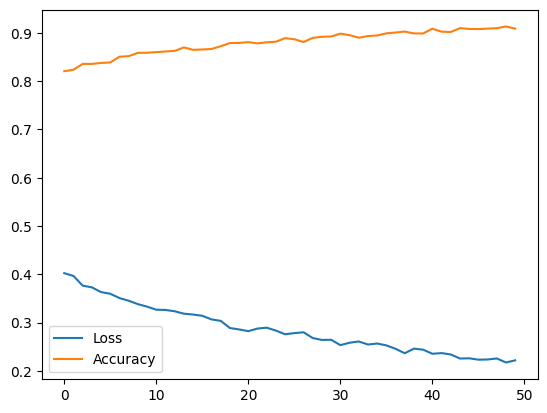

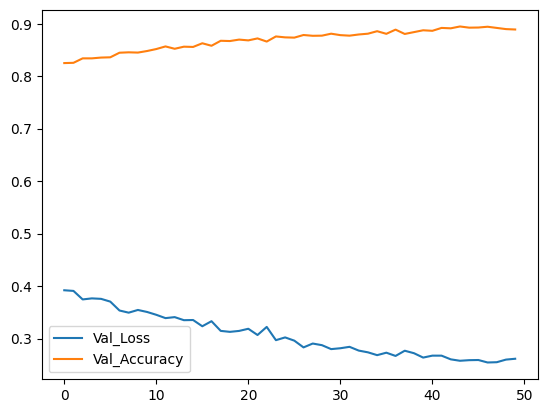

In [13]:
# loss curve

l = np.concatenate([history_ft.history['loss']])
acc = np.concatenate([history_ft.history['accuracy']])
lv = np.concatenate([history_ft.history['val_loss']])
accv = np.concatenate([history_ft.history['val_accuracy']])

plt.plot(l, label="Loss")
plt.plot(acc, label="Accuracy")
plt.legend()
plt.show()
plt.plot(lv, label="Val_Loss")
plt.plot(accv, label="Val_Accuracy")
plt.legend()
plt.show()

In [14]:
model.evaluate(te_set)

32/32 ━━━━━━━━━━━━━━━━━━━━ 24s 733ms/step - accuracy: 0.9025 - loss: 0.2321


[0.2544706463813782, 0.8942499756813049]